In [ ]:


import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import platform
import datetime
import os
import math
import random

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)



Python version: 3.8.16
Tensorflow version: 2.9.2
Keras version: 2.9.0


In [ ]:


# Load the TensorBoard notebook extension.
# %reload_ext tensorboard
%load_ext tensorboard



In [ ]:
DATASET_NAME = 'rock_paper_scissors'

(dataset_train_raw, dataset_test_raw), dataset_info = tfds.load(
    name=DATASET_NAME,
    data_dir='tmp',
    with_info=True,
    as_supervised=True,
    split=[tfds.Split.TRAIN, tfds.Split.TEST],
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2520 [00:00<?, ? examples/s]

Shuffling tmp/rock_paper_scissors/3.0.0.incompleteM81GM5/rock_paper_scissors-train.tfrecord*...:   0%|        …

Generating test examples...:   0%|          | 0/372 [00:00<?, ? examples/s]

Shuffling tmp/rock_paper_scissors/3.0.0.incompleteM81GM5/rock_paper_scissors-test.tfrecord*...:   0%|         …

Dataset rock_paper_scissors downloaded and prepared to tmp/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


In [ ]:


print('Raw train dataset:', dataset_train_raw)
print('Raw train dataset size:', len(list(dataset_train_raw)), '\n')

print('Raw test dataset:', dataset_test_raw)
print('Raw test dataset size:', len(list(dataset_test_raw)), '\n')



Raw train dataset: <PrefetchDataset element_spec=(TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
Raw train dataset size: 2520 

Raw test dataset: <PrefetchDataset element_spec=(TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
Raw test dataset size: 372 



In [ ]:


NUM_TRAIN_EXAMPLES = dataset_info.splits['train'].num_examples
NUM_TEST_EXAMPLES = dataset_info.splits['test'].num_examples
NUM_CLASSES = dataset_info.features['label'].num_classes

print('Number of TRAIN examples:', NUM_TRAIN_EXAMPLES)
print('Number of TEST examples:', NUM_TEST_EXAMPLES)
print('Number of label classes:', NUM_CLASSES)



Number of TRAIN examples: 2520
Number of TEST examples: 372
Number of label classes: 3


In [ ]:


INPUT_IMG_SIZE_ORIGINAL = dataset_info.features['image'].shape[0]
INPUT_IMG_SHAPE_ORIGINAL = dataset_info.features['image'].shape

INPUT_IMG_SIZE_REDUCED = INPUT_IMG_SIZE_ORIGINAL // 2
INPUT_IMG_SHAPE_REDUCED = (
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SHAPE_ORIGINAL[2]
)

# Here we may switch between bigger or smaller image sized that we will train our model on.
INPUT_IMG_SIZE = INPUT_IMG_SIZE_REDUCED
INPUT_IMG_SHAPE = INPUT_IMG_SHAPE_REDUCED

In [ ]:


# Function to convert label ID to labels string.
get_label_name = dataset_info.features['label'].int2str
print(get_label_name(0));
print(get_label_name(1));
print(get_label_name(2));


rock
paper
scissors


In [ ]:


def preview_dataset(dataset):
    plt.figure(figsize=(12, 12))
    plot_index = 0
    for features in dataset.take(12):
        (image, label) = features
        plot_index += 1
        plt.subplot(3, 4, plot_index)
        # plt.axis('Off')
        label = get_label_name(label.numpy())
        plt.title('Label: %s' % label)
        plt.imshow(image.numpy())



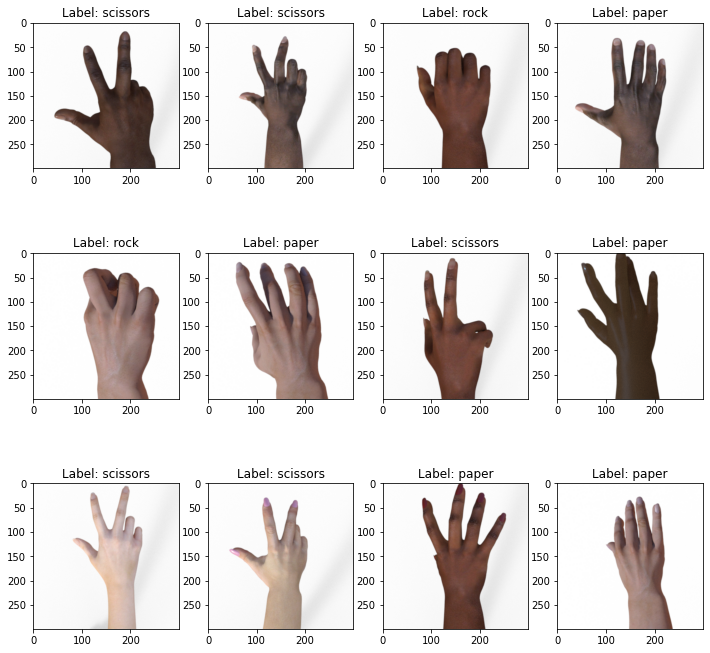

In [ ]:


# Explore raw training dataset images.
preview_dataset(dataset_train_raw)



In [ ]:
def format_example(image, label):
    # Make image color values to be float.
    image = tf.cast(image, tf.float32)
    # Make image color values to be in [0..1] range.
    image = image / 255.
    # Make sure that image has a right size
    image = tf.image.resize(image, [INPUT_IMG_SIZE, INPUT_IMG_SIZE])
    return image, label

In [ ]:


  dataset_train = dataset_train_raw.map(format_example)
  dataset_test = dataset_test_raw.map(format_example)



In [ ]:


# Explore what values are used to represent the image. 
(first_image, first_lable) = list(dataset_train.take(1))[0]
print('Label:', first_lable.numpy(), '\n')
print('Image shape:', first_image.numpy().shape, '\n')
print(first_image.numpy())



Label: 2 

Image shape: (150, 150, 3) 

[[[0.995098   0.995098   0.995098  ]
  [0.995098   0.995098   0.995098  ]
  [0.995098   0.995098   0.995098  ]
  ...
  [0.9852941  0.9852941  0.9852941 ]
  [0.9843137  0.9843137  0.9843137 ]
  [0.98039216 0.98039216 0.98039216]]

 [[0.99607843 0.99607843 0.99607843]
  [0.995098   0.995098   0.995098  ]
  [0.995098   0.995098   0.995098  ]
  ...
  [0.98333335 0.98333335 0.98333335]
  [0.9813726  0.9813726  0.9813726 ]
  [0.98333335 0.98333335 0.98333335]]

 [[0.99607843 0.99607843 0.99607843]
  [0.9941176  0.9941176  0.9941176 ]
  [0.9941176  0.9941176  0.9941176 ]
  ...
  [0.9852941  0.9852941  0.9852941 ]
  [0.9852941  0.9852941  0.9852941 ]
  [0.9813726  0.9813726  0.9813726 ]]

 ...

 [[0.9862745  0.9862745  0.9862745 ]
  [0.98725486 0.98725486 0.98725486]
  [0.9882353  0.9882353  0.9882353 ]
  ...
  [0.9705882  0.9705882  0.9705882 ]
  [0.97352946 0.97352946 0.97352946]
  [0.9754902  0.9754902  0.9754902 ]]

 [[0.9882353  0.9882353  0.9882353

In [ ]:
def augment_flip(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image
    

In [ ]:


def augment_color(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_hue(image, max_delta=0.08)
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    image = tf.image.random_brightness(image, 0.05)
    image = tf.image.random_contrast(image, lower=0.8, upper=1)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image



In [ ]:


def augment_inversion(image: tf.Tensor) -> tf.Tensor:
    random = tf.random.uniform(shape=[], minval=0, maxval=1)
    if random > 0.5:
        image = tf.math.multiply(image, -1)
        image = tf.math.add(image, 1)
    return image



In [ ]:


def augment_color(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_hue(image, max_delta=0.08)
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    image = tf.image.random_brightness(image, 0.05)
    image = tf.image.random_contrast(image, lower=0.8, upper=1)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image



In [ ]:


  def augment_zoom(image: tf.Tensor, min_zoom=0.8, max_zoom=1.0) -> tf.Tensor:
      image_width, image_height, image_colors = image.shape
      crop_size = (image_width, image_height)

      # Generate crop settings, ranging from a 1% to 20% crop.
      scales = list(np.arange(min_zoom, max_zoom, 0.01))
      boxes = np.zeros((len(scales), 4))

      for i, scale in enumerate(scales):
          x1 = y1 = 0.5 - (0.5 * scale)
          x2 = y2 = 0.5 + (0.5 * scale)
          boxes[i] = [x1, y1, x2, y2]

      def random_crop(img):
          # Create different crops for an image
          crops = tf.image.crop_and_resize(
              [img],
              boxes=boxes,
              box_indices=np.zeros(len(scales)),
              crop_size=crop_size
          )
          # Return a random crop
          return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]

      choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

      # Only apply cropping 50% of the time
      return tf.cond(choice < 0.5, lambda: image, lambda: random_crop(image))



In [ ]:


def augment_rotation(image: tf.Tensor) -> tf.Tensor:
    # Rotate 0, 90, 180, 270 degrees
    return tf.image.rot90(
        image,
        tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    )



In [ ]:
def augment_data(image, label):
    image = augment_flip(image)
    image = augment_color(image)
    image = augment_rotation(image)
    image = augment_zoom(image)
    image = augment_inversion(image)
    return image, label

In [ ]:
dataset_train_augmented = dataset_train.map(augment_data)

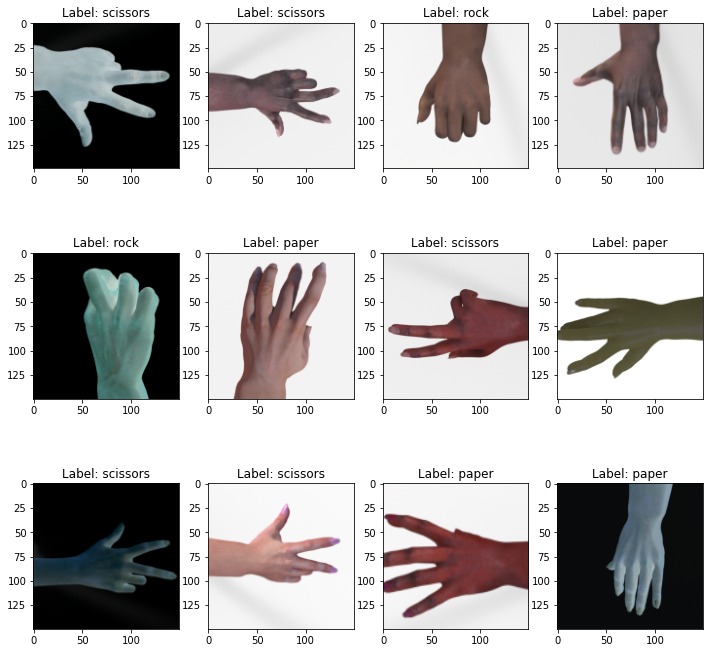

In [ ]:


# Explore augmented training dataset.
preview_dataset(dataset_train_augmented)



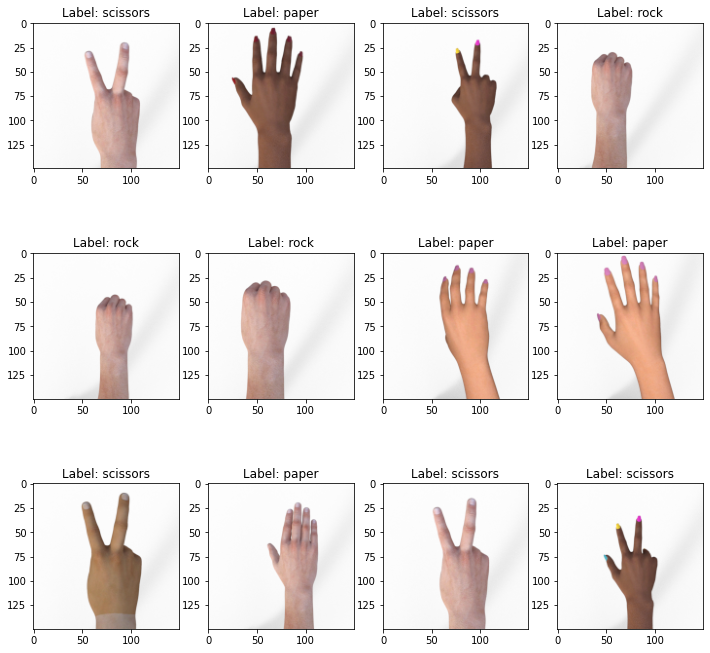

In [ ]:


# Explore test dataset.
preview_dataset(dataset_test)



In [ ]:


BATCH_SIZE = 32

dataset_train_augmented_shuffled = dataset_train_augmented.shuffle(
    buffer_size=NUM_TRAIN_EXAMPLES
)

dataset_train_augmented_shuffled = dataset_train_augmented.batch(
    batch_size=BATCH_SIZE
)

# Prefetch will enable the input pipeline to asynchronously fetch batches while your model is training.
dataset_train_augmented_shuffled = dataset_train_augmented_shuffled.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE
)

dataset_test_shuffled = dataset_test.batch(BATCH_SIZE)



Label batch shape: (32,) 

Image batch shape: (32, 150, 150, 3) 

Label batch: [2 2 0 1 0 1 2 1 2 2 1 1 2 1 1 1 1 1 1 1 1 0 0 0 0 1 1 2 2 2 0 0] 

First batch image: [[[0.01012474 0.01128769 0.01124865]
  [0.01005292 0.01121587 0.01117682]
  [0.00925088 0.01041389 0.0103749 ]
  ...
  [0.00352675 0.00468969 0.00465071]
  [0.00435817 0.00552112 0.00548214]
  [0.00432378 0.00548673 0.00544775]]

 [[0.01090592 0.01206893 0.01202989]
  [0.01093918 0.01210213 0.01206309]
  [0.01248735 0.01365036 0.01361138]
  ...
  [0.00432831 0.00549126 0.00545228]
  [0.00437933 0.00554228 0.0055033 ]
  [0.00436157 0.00552452 0.00548553]]

 [[0.01269346 0.01385647 0.01381743]
  [0.01109797 0.01226097 0.01222193]
  [0.01040041 0.01156336 0.01152432]
  ...
  [0.00369883 0.00486177 0.00482279]
  [0.00507694 0.00623989 0.00620091]
  [0.00267595 0.00383896 0.00379992]]

 ...

 [[0.02536321 0.02652621 0.02648717]
  [0.02882838 0.02999133 0.02995235]
  [0.02632731 0.02749026 0.02745128]
  ...
  [0.01306587 0.01422

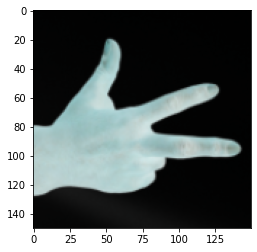

In [ ]:


# Debugging the batches using conversion to Numpy arrays.
batches = tfds.as_numpy(dataset_train_augmented_shuffled)
for batch in batches:
    image_batch, label_batch = batch
    print('Label batch shape:', label_batch.shape, '\n')
    print('Image batch shape:', image_batch.shape, '\n')
    print('Label batch:', label_batch, '\n')
    
    for batch_item_index in range(len(image_batch)):
        print('First batch image:', image_batch[batch_item_index], '\n')
        plt.imshow(image_batch[batch_item_index])
        plt.show()
        # Break to shorten the output.
        break
    # Break to shorten the output.
    break



In [ ]:
model = tf.keras.models.Sequential()

# First convolution.
model.add(tf.keras.layers.Convolution2D(
    input_shape=INPUT_IMG_SHAPE,
    filters=64,
    kernel_size=3,
    activation=tf.keras.activations.relu
))
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

# Second convolution.
model.add(tf.keras.layers.Convolution2D(
    filters=64,
    kernel_size=3,
    activation=tf.keras.activations.relu
))
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

# Third convolution.
model.add(tf.keras.layers.Convolution2D(
    filters=128,
    kernel_size=3,
    activation=tf.keras.activations.relu
))
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

# Fourth convolution.
model.add(tf.keras.layers.Convolution2D(
    filters=128,
    kernel_size=3,
    activation=tf.keras.activations.relu
))
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

# Flatten the results to feed into dense layers.
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))

# 512 neuron dense layer.
model.add(tf.keras.layers.Dense(
    units=512,
    activation=tf.keras.activations.relu
))

# Output layer.
model.add(tf.keras.layers.Dense(
    units=NUM_CLASSES,
    activation=tf.keras.activations.softmax
))

In [ ]:


model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

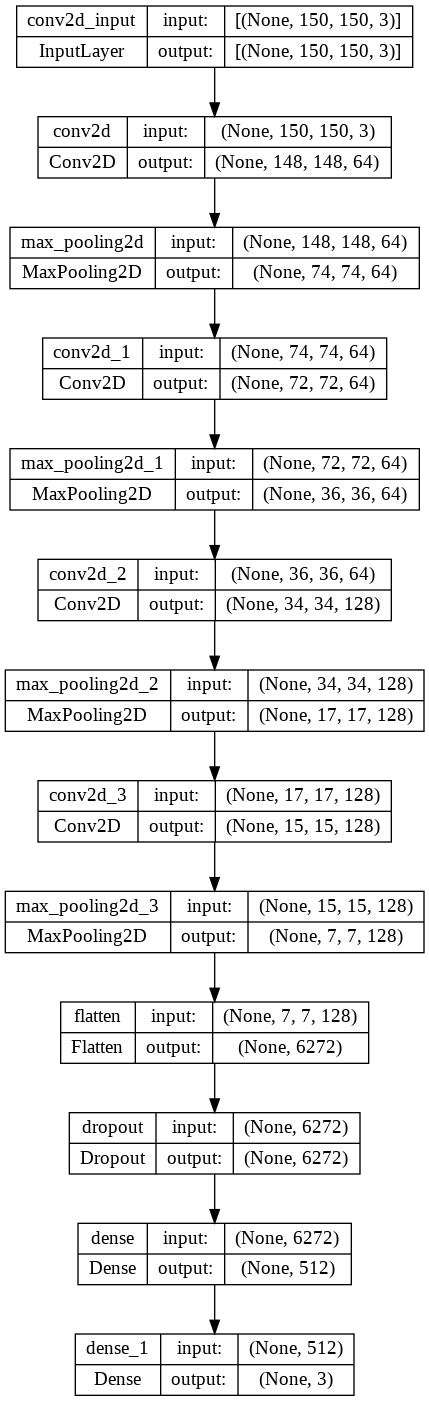

In [ ]:


tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)



In [ ]:


# adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
rmsprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

model.compile(
    optimizer=rmsprop_optimizer,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)



In [ ]:


steps_per_epoch = NUM_TRAIN_EXAMPLES // BATCH_SIZE
validation_steps = NUM_TEST_EXAMPLES // BATCH_SIZE

print('steps_per_epoch:', steps_per_epoch)
print('validation_steps:', validation_steps)



steps_per_epoch: 78
validation_steps: 11


In [ ]:


!rm -rf tmp/checkpoints
!rm -rf logs



In [ ]:


# Preparing callbacks.
os.makedirs('logs/fit', exist_ok=True)
tensorboard_log_dir = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=tensorboard_log_dir,
    histogram_freq=1
)

os.makedirs('tmp/checkpoints', exist_ok=True)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='tmp/checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='val_accuracy'
    # monitor='val_loss'
)



In [ ]:


training_history = model.fit(
    x=dataset_train_augmented_shuffled.repeat(),
    validation_data=dataset_test_shuffled.repeat(),
    epochs=15,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[
        # model_checkpoint_callback,
        # early_stopping_callback,
        tensorboard_callback
    ],
    verbose=1
)



Epoch 1/15
78/78 [==============================] - 25s 206ms/step - loss: 1.0672 - accuracy: 0.4868 - val_loss: 0.9888 - val_accuracy: 0.4915
Epoch 2/15
78/78 [==============================] - 16s 206ms/step - loss: 0.5519 - accuracy: 0.7801 - val_loss: 0.6233 - val_accuracy: 0.6648
Epoch 3/15
78/78 [==============================] - 18s 234ms/step - loss: 0.3516 - accuracy: 0.8746 - val_loss: 0.4373 - val_accuracy: 0.7784
Epoch 4/15
78/78 [==============================] - 21s 270ms/step - loss: 0.2744 - accuracy: 0.9068 - val_loss: 0.3345 - val_accuracy: 0.8665
Epoch 5/15
78/78 [==============================] - 19s 243ms/step - loss: 0.1927 - accuracy: 0.9349 - val_loss: 0.5749 - val_accuracy: 0.7301
Epoch 6/15
78/78 [==============================] - 25s 321ms/step - loss: 0.1359 - accuracy: 0.9594 - val_loss: 0.4209 - val_accuracy: 0.8097
Epoch 7/15
78/78 [==============================] - 25s 327ms/step - loss: 0.1230 - accuracy: 0.9582 - val_loss: 0.2834 - val_accuracy: 0.8494

In [ ]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    accuracy = training_history.history['accuracy']
    val_accuracy = training_history.history['val_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.show()

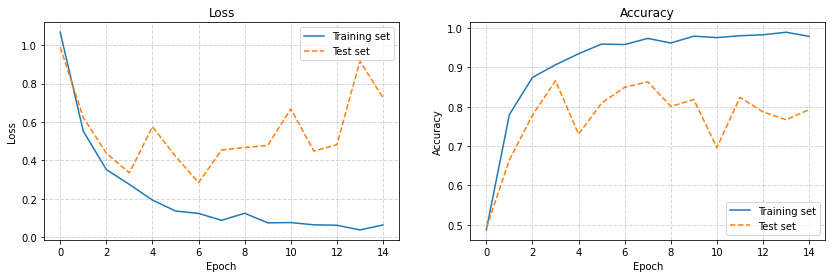

In [ ]:


render_training_history(training_history)



In [ ]:


# %%capture
train_loss, train_accuracy = model.evaluate(
    x=dataset_train.batch(BATCH_SIZE).take(NUM_TRAIN_EXAMPLES)
)

test_loss, test_accuracy = model.evaluate(
    x=dataset_test.batch(BATCH_SIZE).take(NUM_TEST_EXAMPLES)
)



12/12 [==============================] - 1s 82ms/step - loss: 0.7347 - accuracy: 0.7930


In [ ]:


print('Training loss: ', train_loss)
print('Training accuracy: ', train_accuracy)
print('\n')
print('Test loss: ', test_loss)
print('Test accuracy: ', test_accuracy)



Training loss:  0.06999921053647995
Training accuracy:  0.9607142806053162


Test loss:  0.7346906661987305
Test accuracy:  0.7930107712745667


In [ ]:


model_name = 'rock_paper_scissors_cnn.h5'
model.save(model_name, save_format='h5')



In [ ]:
!mkdir -p saved_model
model.save('saved_model/my_model')


In [ ]:
!zip -r /content/file.zip /content/saved_model/my_model

  adding: content/saved_model/my_model/ (stored 0%)
  adding: content/saved_model/my_model/variables/ (stored 0%)
  adding: content/saved_model/my_model/variables/variables.index (deflated 67%)
  adding: content/saved_model/my_model/variables/variables.data-00000-of-00001 (deflated 11%)
  adding: content/saved_model/my_model/assets/ (stored 0%)
  adding: content/saved_model/my_model/saved_model.pb (deflated 89%)
  adding: content/saved_model/my_model/keras_metadata.pb (deflated 93%)
